fk-ik_1 각도 보정, fk(T행렬적용)

In [2]:
# fk-ik_1 각도 보정, fk(T행렬적용)

import math
import sympy as sp

# 링크 길이 (mm)
L1 = 7.8
L2 = 8.3
L3 = 3.9

# Forward Kinematics
def fk_3dof(theta1_deg, theta2_deg, theta3_deg):

    joint_limits = {
    'theta1': (-135, 225),     # base 회전
    'theta2': (-30, 180),    # shoulder
    'theta3': (-135, 200),     # elbow
    }

    # # 범위 검사
    # input_angles = {'theta1': theta1_deg, 'theta2': theta2_deg, 'theta3': theta3_deg}
    # for name, angle in input_angles.items():
    #     min_angle, max_angle = joint_limits[name]
    #     if not (min_angle <= angle <= max_angle):
    #         return None, f"[오류] {name}={angle:.1f}°: 가동 범위 초과"

    # === 각보정 ===
    # theta3_deg = 90 - theta3_deg 

    # 각도 변환
    t1 = math.radians(theta1_deg)
    t2 = math.radians(theta2_deg)
    t3 = math.radians(theta3_deg)

    # DH 변환행렬 함수
    def dh_transform(theta, d, a, alpha):
        return sp.Matrix([ 
        [sp.cos(theta), -sp.sin(theta)*sp.cos(alpha),  sp.sin(theta)*sp.sin(alpha), a*sp.cos(theta)],
        [sp.sin(theta),  sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
        [0,              sp.sin(alpha),                sp.cos(alpha),               d],
        [0,              0,                            0,                           1]
        ])

    # Transformation Matrix
    dh_params = [
    [t1, L1, 0, math.radians(90)],
    [t2, 0, L2, 0],
    [t3, 0, L3, 0],
    ]
    
    T = sp.eye(4)
    for params in dh_params:
        Ti = dh_transform(*params)
        T = T * Ti

    T = sp.simplify(T)
    x = round(T[0, 3], 2)
    y = round(T[1, 3], 2)
    z = round(T[2, 3], 2)
    
    return (x, y, z)
# , None

def ik_3dof(x, y, z):
    
    # theta1
    if abs(x) < 1e-4 and abs(y) < 1e-4:
        theta1_deg = 90.0  # 예외 처리
    else:
        theta1_deg = math.degrees(math.atan2(y, x))

    # theta1 = math.atan2(y, x)
    # theta1_deg = math.degrees(theta1)

    # 조인트2 기준으로 평면 거리(r) 및 높이(z_offset)
    r = math.hypot(y, x)
    z_offset = z - L1  # shoulder (조인트2) 기준으로 변환
    d = math.hypot(r, z_offset)

    if d > (L2 + L3):
        return None, "Unreachable: 목표 좌표가 팔 길이보다 멉니다."

    # cos_theta3 = (L2**2 + L3**2 - d**2) / (2 * L2 * L3) # L2, L3 사이 끼인각
    cos_theta3 = (d**2 - L2**2 - L3**2) / (2 * L2 * L3) # 실제 theta3 각 (180 - 끼인각 = theta3)
    cos_theta3 = max(-1.0, min(1.0, cos_theta3))
    theta3 = math.atan2(+math.sqrt(1-cos_theta3**2), cos_theta3)
    # theta3 = math.acos(cos_theta3)
    theta3_deg = round(math.degrees(theta3), 2)

    # theta2
    alpha = math.atan2(z_offset, r)
    cos_beta = ((L2**2 + d**2 - L3**2) / (2 * L2 * d))
    cos_beta = max(min(cos_beta, 1.0), -1.0)
    beta = math.atan2(+math.sqrt(1-cos_beta**2), cos_beta)
    # beta = math.acos((L2**2 + d**2 - L3**2) / (2 * L2 * d))
    theta2 = alpha - beta
    theta2_deg = round(math.degrees(theta2), 2)

    return (theta1_deg, theta2_deg, theta3_deg)

In [3]:
# fk-ik 각도 test code
def test_fk_ik_consistency(theta1, theta2, theta3):
    print("🔧 테스트 각도:", theta1, theta2, theta3)
    pos = fk_3dof(theta1, theta2, theta3)
    print("→ FK 좌표:", pos)
    angles = ik_3dof(*pos)
    print("→ IK 결과:", angles)
    if isinstance(angles, tuple):
        err = tuple(round(angles[i] - a, 3) for i, a in enumerate([theta1, theta2, theta3]))
        print("→ 오차 (deg):", err)
    print("-" * 40)

# 예제 실행
test_fk_ik_consistency(30, 30, 30)
test_fk_ik_consistency(45, 45, 45)
test_fk_ik_consistency(90, 30, 120)


🔧 테스트 각도: 30 30 30
→ FK 좌표: (7.91, 4.57, 15.33)
→ IK 결과: (30.018367427609085, 30.01, 30.01)
→ 오차 (deg): (0.018, 0.01, 0.01)
----------------------------------------
🔧 테스트 각도: 45 45 45
→ FK 좌표: (4.15, 4.15, 17.57)
→ IK 결과: (45.0, 45.01, 44.97)
→ 오차 (deg): (0.0, 0.01, -0.03)
----------------------------------------
🔧 테스트 각도: 90 30 120
→ FK 좌표: (0.0, 3.81, 13.90)
→ IK 결과: (90.0, 30.0, 120.0)
→ 오차 (deg): (0.0, 0.0, 0.0)
----------------------------------------


In [ ]:
# fk-ik 각도 error 조사 (각도)
def test_all_fk_ik_combinations(step=10):
    results = []
    for theta1 in range(0, 181, step):
        for theta2 in range(0, 181, step):
            for theta3 in range(0, 181, step):
                pos = fk_3dof(theta1, theta2, theta3)
                angles = ik_3dof(*pos)
                
                if isinstance(angles, tuple) and None not in angles:
                    err = tuple(round(angles[i] - a, 3) for i, a in enumerate([theta1, theta2, theta3]))
                    results.append((theta1, theta2, theta3, *err))
                else:
                    results.append((theta1, theta2, theta3, 'unreachable', 'unreachable', 'unreachable'))
    return results

# 실행 및 일부 결과 출력
results = test_all_fk_ik_combinations()

# 예시 출력 (앞의 10개만 보기)
for row in results[:10]:
    print(row)

(0, 0, 0, 0.0, -0.11, 0.35)
(0, 0, 10, 0.0, -0.01, 0.07)
(0, 0, 20, 0.0, -0.11, 0.32)
(0, 0, 30, 0.0, 0.03, -0.11)
(0, 0, 40, 0.0, 0.04, -0.1)
(0, 0, 50, 0.0, 0.04, -0.1)
(0, 0, 60, 0.0, 0.02, -0.02)
(0, 0, 70, 0.0, -0.04, 0.09)
(0, 0, 80, 0.0, -0.0, -0.05)
(0, 0, 90, 0.0, -0.0, -0.01)


[2769, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1316, 1964, 228, 76, 171, 57, 114, 0, 0, 0, 0, 0, 0] 6731
6731


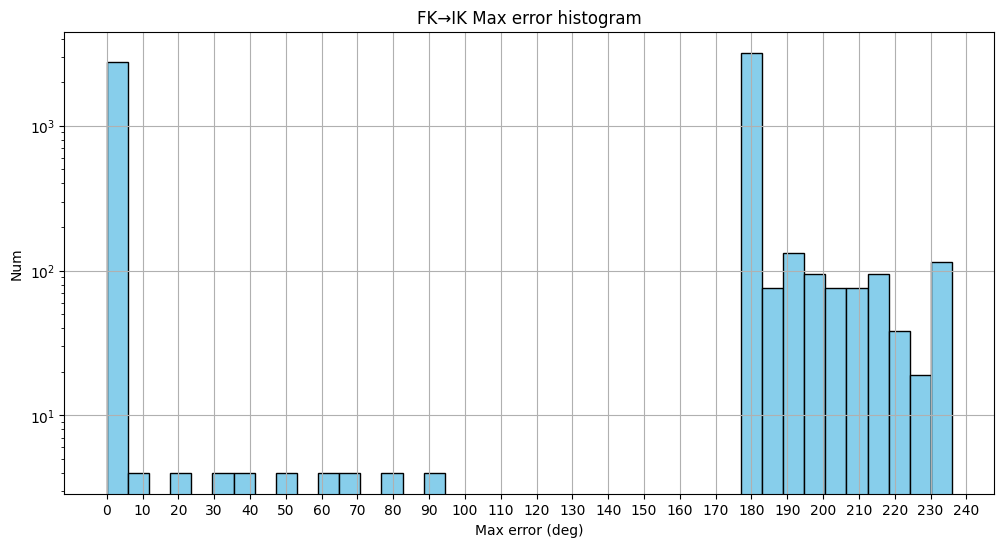

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcdefaults()

def plot_error_histogram(results):

    errors = []
    for row in results:
        _, _, _, e1, e2, e3 = row
        if isinstance(e1, (float, int)):
            max_err = max(abs(e1), abs(e2), abs(e3))
            errors.append(max_err)
    
    ranges = []
    for i in range(0, 300, 10):
        ranges.append((i, i + 10))

    counts = [sum(1 for x in errors if start <= x < end) for start, end in ranges]

    print(counts, sum(counts))  # 출력: [1, 4, 2]

    print(len(errors))
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=40, color='skyblue',  edgecolor='black', log=True)
    plt.xlabel("Max error (deg)")
    plt.ylabel("Num")
    plt.title("FK→IK Max error histogram")
    plt.grid(True)

    x_min = int(min(errors) // 10 * 10)
    x_max = int((max(errors) // 10 + 1) * 10)
    plt.xticks(np.arange(x_min, x_max + 1, 10))
    plt.show()
    
plot_error_histogram(results)

In [ ]:
# fk-ik 좌표 error 조사 (좌표)
def test_all_fk_ik_combinations(step=10):
    pos_results = []
    for theta1 in range(0, 181, step):
        for theta2 in range(0, 181, step):
            for theta3 in range(0, 181, step):
                pos = fk_3dof(theta1, theta2, theta3)  # (x, y, z)
                
                angles = ik_3dof(*pos) #(theta1, theta2, theta3)
                if angles is None or isinstance(angles, tuple) and None in angles:
                    pos_results.append((*pos, 'unreachable', 'unreachable', 'unreachable'))
                    continue
                
                ik_pos = fk_3dof(*angles) # (x, y, z)
                if ik_pos is None or isinstance(ik_pos, tuple) and None in ik_pos:
                    pos_results.append((*pos, 'unreachable', 'unreachable', 'unreachable'))
                    continue

                # 좌표 오차 계산 (x, y, z 오차 각각)
                err = tuple(round(ik_p - p, 4) for p, ik_p in zip(pos, ik_pos))
                pos_results.append((*pos, *err))
    return pos_results

# 실행 및 일부 결과 출력
pos_results = test_all_fk_ik_combinations()

# 예시 출력 (앞의 10개만 보기)
for row in pos_results[:10]:
    print(row)

(12.20, 0, 7.80, 0, 0, 0)
(12.14, 0.0, 8.48, 0, 0, 0)
(11.96, 0.0, 9.13, 0, 0, 0)
(11.68, 0.0, 9.75, 0, 0, 0)
(11.29, 0.0, 10.31, 0, 0, 0)
(10.81, 0.0, 10.79, 0, 0, 0)
(10.25, 0.0, 11.18, 0, 0, 0)
(9.63, 0.0, 11.46, 0, 0, 0)
(8.98, 0.0, 11.64, 0, 0, 0)
(8.30, 0.0, 11.70, 0, 0, 0)


In [43]:
from collections import Counter

# dx, dy, dz 값만 추출
errors = [(row[3], row[4], row[5]) for row in pos_results]

# 고유 튜플별 개수 세기
error_counts = Counter(errors)

# 정렬하여 출력
for error_value, count in error_counts.items():
    print(f"{error_value} → {count}개")


(0, 0, 0) → 6695개
(0.0098, 0, 0) → 4개
('unreachable', 'unreachable', 'unreachable') → 128개
(0, 0, 0.0099) → 22개
(-0.0098, 0, 0) → 4개
(0, 0.0098, 0) → 3개
(0, -0.0098, 0) → 3개


0


/home/choigh/venv/gen_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


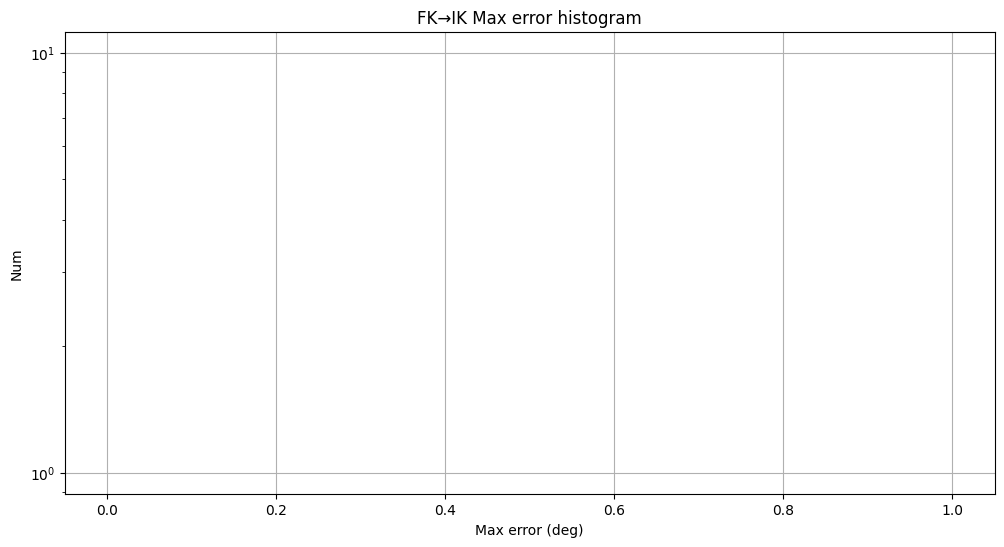

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcdefaults()

def plot_error_histogram(pos_results):

    errors = []
    for row in pos_results:
        _, _, _, e1, e2, e3 = row
        if isinstance(e1, (float, int)):
            max_err = max(abs(e1), abs(e2), abs(e3))
            errors.append(max_err)

    print(len(errors))

    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=10, color='skyblue',  edgecolor='black', log=True)
    plt.xlabel("Max error (deg)")
    plt.ylabel("Num")
    plt.title("FK→IK Max error histogram")
    plt.grid(True)
    plt.show()
    
plot_error_histogram(pos_results)

fk-ik_2 각도 보정 X

In [ ]:
# fk-ik_2 각도 보정 X

import math

# 링크 길이 (cm 또는 mm, 단위 일치만 유지)
L1 = 7.8
L2 = 8.3
L3 = 3.9

def fk_3dof(theta1_deg, theta2_deg, theta3_deg):
    
    # === 서보 보정 ===
    # theta1_deg = theta1_deg - 90
    # theta3_deg = 90 - theta3_deg 
    
    # 라디안 변환
    t1 = math.radians(theta1_deg)
    t2 = math.radians(theta2_deg)
    t3 = math.radians(theta3_deg)

    # 위치 계산
    x = math.cos(t1) * (L2 * math.cos(t2) + L3 * math.cos(t2 + t3))
    y = math.sin(t1) * (L2 * math.cos(t2) + L3 * math.cos(t2 + t3))
    z = L1 + L2 * math.sin(t2) + L3 * math.sin(t2 + t3)

    return round(x, 2), round(y, 2), round(z, 2)


def ik_3dof(x, y, z):
    # θ1
    theta1 = math.atan2(y, x)
    theta1_deg = math.degrees(theta1)
    # theta1_deg = (theta1 + 90) % 360

    # 평면 거리, z offset
    r = math.hypot(x, y)
    z_offset = z - L1
    d = math.hypot(r, z_offset)

    if d > (L2 + L3):
        return None, "Unreachable"

    # θ3
    cos_theta3 = (d**2 - L2**2 - L3**2) / (2 * L2 * L3)
    cos_theta3 = max(-1.0, min(1.0, cos_theta3))
    theta3 = math.acos(cos_theta3)
    theta3_deg = math.degrees(theta3)
    # theta3_deg = (450 - theta3_deg) % 360 # 각보정

    # θ2
    alpha = math.atan2(z_offset, r)
    beta = math.acos((L2**2 + d**2 - L3**2) / (2 * L2 * d))
    theta2 = alpha - beta  # elbow-down
    theta2_deg = math.degrees(theta2)

    return round(theta1_deg, 2), round(theta2_deg, 2), round(theta3_deg, 2)


In [57]:
# fk-ik 각도 test code
def test_fk_ik_consistency(theta1, theta2, theta3):
    print("🔧 테스트 각도:", theta1, theta2, theta3)
    pos = fk_3dof(theta1, theta2, theta3)
    print("→ FK 좌표:", pos)
    angles = ik_3dof(*pos)
    print("→ IK 결과:", angles)
    if isinstance(angles, tuple):
        err = tuple(round(angles[i] - a, 3) for i, a in enumerate([theta1, theta2, theta3]))
        print("→ 오차 (deg):", err)
    print("-" * 40)

# 예제 실행
test_fk_ik_consistency(90, 90, 160)
test_fk_ik_consistency(45, 45, 45)
test_fk_ik_consistency(90, 30, 120)


🔧 테스트 각도: 90 90 160
→ FK 좌표: (0.0, -1.33, 12.44)
→ IK 결과: (-90.0, 57.89, 159.91)
→ 오차 (deg): (-180.0, -32.11, -0.09)
----------------------------------------
🔧 테스트 각도: 45 45 45
→ FK 좌표: (4.15, 4.15, 17.57)
→ IK 결과: (45.0, 45.01, 44.97)
→ 오차 (deg): (0.0, 0.01, -0.03)
----------------------------------------
🔧 테스트 각도: 90 30 120
→ FK 좌표: (0.0, 3.81, 13.90)
→ IK 결과: (90.0, 30.0, 120.0)
→ 오차 (deg): (0.0, 0.0, 0.0)
----------------------------------------
